## 概述

现代数据天气预报(numerical weather prediction, NWP)可以追溯到1920年，其基于物理原理，整合了几代气象学者的成果经验，是各国气象部门所采用主流的天气预报方法。其中来自欧洲中期天气预报中心(ECMWF)的高分辨率综合系统模型(IFS)表现效果最佳.

本团队利用NVIDIA提出的SHT（球谐波变换）算子与本团队开发的KNO算法相结合，提出了一套气象预测的算法。能够在6小时间隔、1.4度的分辨率上对全球关键天气指标进行预测。该算法在中长期气象预测上具有很大优势。SHT算子的详细信息可以参考：- ["Spherical Fourier Neural Operators:Learning Stable Dynamics on the Sphere"](https://arxiv.org/pdf/2306.03838.pdf) arXiv:2306.03838

以往的气象预测模型都将气象数据视为一个平面结构进行处理。在短期预测时，这种设计能对气象数据进行很好的拟合。但是，当预测的时间增加后，以往的工作在视觉和光谱上会出现明显的尾影，使得预测的结果与真实结果存在较大的差异。因此，本项目将气象数据视为一个球面，采用SHT算子对KNO模型中编码的气象数据进行处理。通过球谐波变换的拟合，本项目在中长期预报上，对以往的工作具有很大的优势。

## 问题描述

本案例将SKNO应用于气象领域，显著提升了长期天气预报的准确度。

## 技术路径

MindEarth求解该问题的具体流程如下：

1. 模型构建
2. 损失函数
3. 模型训练
4. 模型验证和可视化

## SKNO

SKNO模型主要由三部分组成，分别是Encoder、SKNOBlock、Decoder。在模型中，输入的数据先通过Encoder进行编码，编码后的特征利用SKNOBlock进行特征增强和学习，增强后的特征利用Decoder进行解码还原。

![SKNO](./images/SKNO.PNG "Model")

模型的训练流程如下

In [ ]:
import os

from mindspore import context, Model
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.loss_scale_manager import DynamicLossScaleManager
from mindearth.utils import load_yaml_config, create_logger, plt_data
from mindearth import Trainer, SIZE_DICT
from mindearth.data import Dataset, Era5Data

from src.skno import SKNO
from src.callback import EvaluateCallBack, InferenceModule, MultiMSELoss, CustomWithLossCell

 `src` 文件可以从 `MindEarth/applications/SKNO/src`下载.

In [3]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

In [4]:
config = load_yaml_config('./skno.yaml')
config['model']['data_sink'] = False

config['train']['distribute'] = False
config['train']['amp_level'] = 'O2'

config['data']['num_workers'] = 1
config['data']['grid_resolution'] = 1.4
config['data']['h_size'], config['data']['w_size'] = SIZE_DICT[1.4]

config['optimizer']['epochs'] = 10
config['optimizer']['finetune_epochs'] = 1
config['optimizer']['warmup_epochs'] = 1
config['optimizer']['initial_lr'] = 5e-4

config['summary']["valid_frequency"] = 10
config['summary']["summary_dir"] = './summary'

logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

model、data和optimizer的参数可以通过 `config`获取.

## 模型构建

模型的计算流程：

- 分支一 （Prediction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 编码后的数据在SKNO blocks进行球谐波变换，并在频域进行非线性变换。
    3. Decoder模块对SKNO blocks输出的数据进行还原，得到最终预测输出

- 分支二 （Reconstruction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 将Encoder模块的输出作为Decoder模块的输入，实现对输入数据的重建。

In [5]:
data_params = config['data']
model_params = config['model']

model = SKNO(image_size=(data_params["h_size"], data_params["w_size"]),
             in_channels=data_params["feature_dims"],
             out_channels=data_params["feature_dims"],
             patch_size=data_params["patch_size"],
             encoder_depths=model_params["encoder_depth"],
             encoder_embed_dims=model_params["encoder_embed_dim"],
             mlp_ratio=model_params["mlp_ratio"],
             dropout_rate=model_params["dropout_rate"],
             num_blocks=model_params["num_blocks"],
             high_freq=True,
             encoder_network=model_params["encoder_network"],
             compute_dtype=compute_type)

## 损失函数

SKNO使用多loss的训练方法，包括Prediction loss，Reconstruction loss，两者均基于mean squared error。

In [6]:
loss_fn = MultiMSELoss()
loss_net = CustomWithLossCell(model, loss_fn)

## 模型训练

模型训练阶段继承了Trainer类，同时重写了get_callback，get_solver两个成员函数，以便于能在训练阶段执行测试验证；

In [9]:
class SKNOEra5Data(Era5Data):
    def _patch(self, x, img_size, patch_size, output_dims):
        """ Partition the data into patches. """
        if self.run_mode == 'valid' or self.run_mode == 'test':
            x = x.transpose(1, 0, 2, 3)
        return x


class SKNOTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super(SKNOTrainer, self).__init__(config, model, loss_fn, logger)
        self.pred_cb = self.get_callback()

    def get_dataset(self):
        """
        Get train and valid dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = SKNOEra5Data(data_params=self.data_params, run_mode='train')
        valid_dataset_generator = SKNOEra5Data(data_params=self.data_params, run_mode='valid')

        train_dataset = Dataset(train_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'])
        valid_dataset = Dataset(valid_dataset_generator, distribute=False, num_workers=self.data_params['num_workers'],
                                shuffle=False)
        train_dataset = train_dataset.create_dataset(self.data_params['batch_size'])
        valid_dataset = valid_dataset.create_dataset(self.data_params['batch_size'])
        return train_dataset, valid_dataset

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb

    def get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params['amp_level']
                       )
        return solver

trainer = SKNOTrainer(config, model, loss_net, logger)

2023-06-14 16:32:25,529 - pretrain.py[line:185] - INFO: steps_per_epoch: 51


### 模型训练

In [10]:
trainer.train()

[WARNING] ME(2077038:281473073187392,MainProcess):2023-06-14-16:32:41.768.379 [mindspore/train/model.py:1079] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 51, loss is 0.3574
Train epoch time: 207430.749 ms, per step time: 4067.270 ms
epoch: 2 step: 51, loss is 0.1454
Train epoch time: 81535.823 ms, per step time: 1598.742 ms
epoch: 3 step: 51, loss is 0.1161
Train epoch time: 72050.728 ms, per step time: 1412.759 ms
epoch: 4 step: 51, loss is 0.1001
Train epoch time: 61775.083 ms, per step time: 1211.276 ms
epoch: 5 step: 51, loss is 0.0924
Train epoch time: 66319.851 ms, per step time: 1300.389 ms
epoch: 6 step: 51, loss is 0.08624
Train epoch time: 79226.068 ms, per step time: 1553.452 ms
epoch: 7 step: 51, loss is 0.0821
Train epoch time: 70075.950 ms, per step time: 1374.038 ms
epoch: 8 step: 51, loss is 0.0803
Train epoch time: 85439.355 ms, per step time: 1675.281 ms
epoch: 9 step: 51, loss is 0.07874
Train epoch time: 77829.153 ms, per step time: 1526.062 ms
epoch: 10 step: 51, loss is 0.07874
Train epoch time: 85230.132 ms, per step time: 1671.179 ms


2023-06-14 16:47:28,699 - forecast.py[line:298] - INFO: ================================Start Evaluation================================
2023-06-14 16:50:11,144 - forecast.py[line:311] - INFO: 8
2023-06-14 16:50:32,736 - forecast.py[line:311] - INFO: 16
2023-06-14 16:50:51,936 - forecast.py[line:311] - INFO: 24
2023-06-14 16:50:54,374 - forecast.py[line:312] - INFO: test dataset size: 24
2023-06-14 16:50:54,382 - forecast.py[line:315] - INFO: mean lat_weighted_rmse t = 1: [0.13089216 0.12066304 0.11840134 0.11955951 0.12320521 0.12318747
 0.1261079  0.1286016  0.13340563 0.14141321 0.16622295 0.19030848
 0.22018009 0.30250594 0.50656687 0.57449878 0.58346216 0.57935051
 0.5694385  0.56782318 0.53484598 0.48324674 0.47550295 0.39973541
 0.27637048 0.25593577 0.19159049 0.17502819 0.20519591 0.22717911
 0.20940391 0.17413586 0.15795232 0.15568117 0.15534892 0.15234895
 0.17093722 0.17914117 0.18338119 0.23199542 0.28715749 0.28050708
 0.27659595 0.28805336 0.3085602  0.33030782 0.3252457

### 模型推理及可视化


In [9]:
pred_time_index = 0

params = load_checkpoint('./summary/ckpt/step_1/SKNO-10_51.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger, grid_resolution=config['data']['grid_resolution'],
                                   t_out_test=config['data']['t_out_test'])

[WARNING] ME(2110503:281473883515456,MainProcess):2023-06-14-17:10:25.388.642 [mindspore/train/serialization.py:736] For 'load_param_into_net', remove parameter prefix name: _backbone., continue to load.


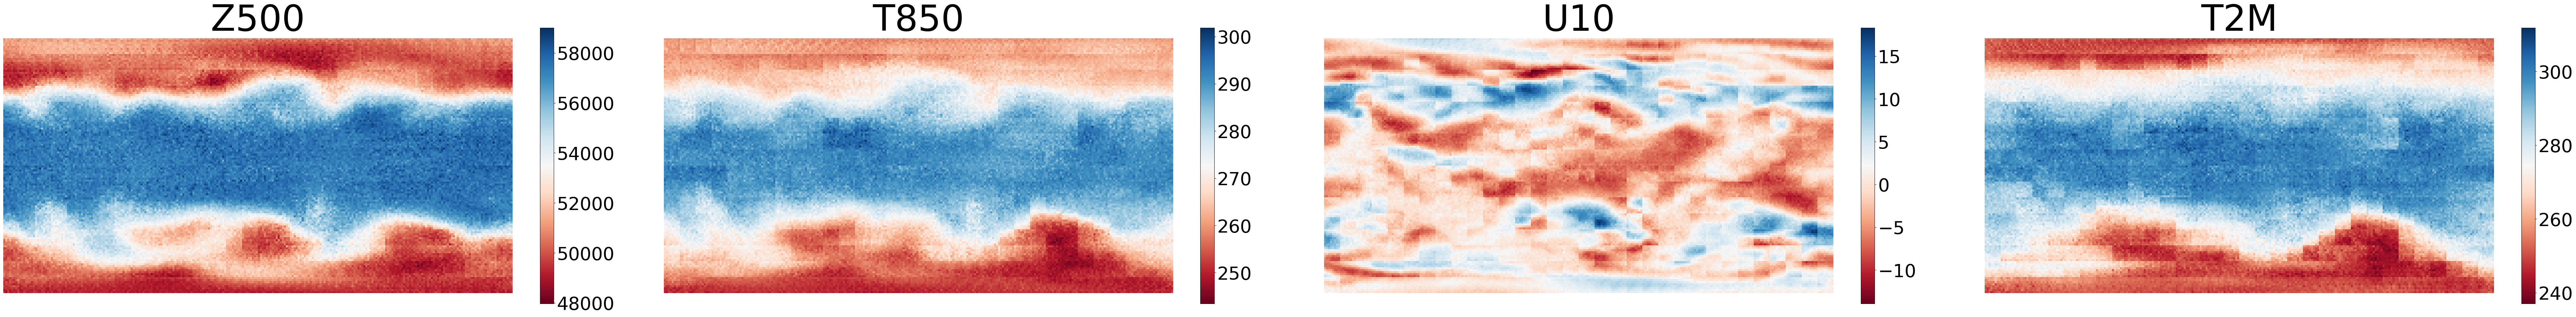

In [10]:
test_dataset_generator = Era5Data(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']

pred = inference_module.forecast(inputs)
pred = pred[pred_time_index].asnumpy()
ground_truth = labels[:, :, pred_time_index, :, :].asnumpy()
plt_data(pred, ground_truth, config['data']['root_dir'])